# Modeling rental prices in the SF Bay Area

This notebook will develop a predictive model for rents in the Bay Area using rental listings from Craigslist. 


**Data:**
The dataset used here is Craigslist listings merged with Census and point of interest data. It includes all unique listings in the 'apartments/housing' section of Craigslist from 11/13/2016 - 3/17/2017. 

Features include: 
- property characteristics (rent, sq ft, # bedrooms, # bathrooms, coordinates)
- neighborhood characteristics at the Census block and block group levels (e.g., med hh income, race)
- jobs accessibility (e.g., jobs within a given radius)
- date listed on craigslist

The data has been cleaned and filtered, but features have not yet been carefully selected.

**Goal:**
Develop a model to predict rent as accurately as possible.



In [1]:
import numpy as np
import pandas as pd
import os
import math

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [44]:
DATA_DIR = os.path.join('..','data','urbansim')

## Load and prepare data

In [3]:
# this particular dataset is a subset of all the features available
infile = 'ba_block_small.csv'
df = pd.read_csv(os.path.join(DATA_DIR,infile))
df = df.ix[:,1:]  # exclude first column, which was empty
print(df.shape)
df.head()

(16560, 70)


/Users/lisa/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  after removing the cwd from sys.path.


,pid,date,region,neighborhood,rent,bedrooms,sqft,rent_sqft,longitude,latitude,...,pctrent,pctblack,pctwhite,pctasian,y17jan,y17feb,y17mar,bgpopden,bgjobden,highlowinc1500m
0,5873897352,2016-11-13,sfbay,dublin / pleasanton / livermore,2250.0,1.0,687.0,3.275109,-121.888125,37.708458,...,64.434687,0.0,0.0,0.0,False,False,False,10.073916,7.875687,1.504727
1,5875136804,2016-11-14,sfbay,dublin / pleasanton / livermore,1995.0,1.0,687.0,2.903930,-121.888125,37.708458,...,64.434687,0.0,0.0,0.0,False,False,False,10.073916,7.875687,1.504727
2,5869197992,2016-11-15,sfbay,dublin / pleasanton / livermore,2395.0,1.0,817.0,2.931457,-121.888125,37.708458,...,64.434687,0.0,0.0,0.0,False,False,False,10.073916,7.875687,1.504727
3,5885759159,2016-11-20,sfbay,dublin / pleasanton / livermore,2250.0,1.0,687.0,3.275109,-121.888125,37.708458,...,64.434687,0.0,0.0,0.0,False,False,False,10.073916,7.875687,1.504727
4,5886665547,2016-11-21,sfbay,dublin / pleasanton / livermore,1995.0,1.0,629.0,3.171701,-121.888125,37.708458,...,64.434687,0.0,0.0,0.0,False,False,False,10.073916,7.875687,1.504727


### What kind of features do we have?

--> **Characteristics of the rental unit**

In [4]:
# Let's look at some summary stats for key features
# property characteristics
df[['rent','sqft','rent_sqft','bedrooms','bathrooms']].describe()

,rent,sqft,rent_sqft,bedrooms,bathrooms
count,16560.000000,16560.000000,16560.000000,16560.000000,8253.000000
mean,2994.327597,978.960870,3.214822,1.617754,1.481764
std,1056.350152,356.909985,1.002537,0.823385,0.564599
min,705.000000,180.000000,0.452830,0.000000,0.000000
25%,2299.000000,734.000000,2.568345,1.000000,1.000000
50%,2783.000000,946.000000,3.067740,2.000000,1.000000
75%,3495.000000,1150.000000,3.676923,2.000000,2.000000
max,12500.000000,4645.000000,9.750000,6.000000,4.000000


--> **Sociodemographics of the neighborhood**

In [5]:
# census features
census_features = ['bgpop', 'bgacres', 'bgjobs', 'bgmedkids', 'bgmedhhs',
       'bgmedinc', 'proprent', 'propwhite','propblack', 'propasian', 'pumahhden', 'prop1per', 'prop2per', 'bgmedagehd',
    'pct1per', 'pct2per', 'pctrent','pctblack', 'pctwhite', 'pctasian', 'bgpopden', 'bgjobden']
df[census_features].describe()

,bgpop,bgacres,bgjobs,bgmedkids,bgmedhhs,bgmedinc,proprent,propwhite,propblack,propasian,...,prop2per,bgmedagehd,pct1per,pct2per,pctrent,pctblack,pctwhite,pctasian,bgpopden,bgjobden
count,16560.000000,16560.000000,16560.000000,16560.000000,16560.000000,16560.000000,16560.000000,16560.000000,16560.000000,16560.000000,...,16560.000000,16560.000000,16560.000000,16560.000000,16560.000000,16560.000000,16560.000000,16560.000000,16559.000000,16559.000000
mean,2278.621558,1677.654083,2619.841486,0.046135,2.121377,86422.977959,0.593939,0.436069,0.035347,0.220206,...,0.336906,45.766697,31.276702,33.690634,59.393853,3.534688,43.606874,22.020556,17.852474,14.368919
std,1692.329312,7599.460446,3897.735448,0.209784,0.623896,29934.893921,0.234371,0.310481,0.096435,0.234738,...,0.092543,7.242487,12.433276,9.254301,23.437098,9.643516,31.048116,23.473798,17.947365,29.362617
min,0.000000,0.000000,0.000000,0.000000,1.000000,21300.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,33.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.003252
25%,1311.000000,78.938239,247.000000,0.000000,2.000000,63050.000000,0.450000,0.000000,0.000000,0.000000,...,0.271248,40.000000,21.786834,27.124774,45.000000,0.000000,0.000000,0.000000,6.577624,1.708691
50%,1746.000000,150.049915,748.000000,0.000000,2.000000,84000.000000,0.603254,0.492701,0.000000,0.155556,...,0.338614,46.500000,30.257009,33.861386,60.325407,0.000000,49.270073,15.555556,13.071077,5.760017
75%,2409.000000,326.435557,3085.000000,0.000000,2.000000,104000.000000,0.789809,0.675676,0.037037,0.380952,...,0.405316,52.000000,39.347768,40.531561,78.980892,3.703704,67.567568,38.095238,23.933577,16.003817
max,10491.000000,42198.002649,19110.000000,1.000000,4.000000,203000.000000,1.000000,1.000000,0.903226,1.000000,...,0.701342,64.000000,81.132075,70.134228,100.000000,90.322581,100.000000,100.000000,125.664465,517.608658


--> **accessibility**

In [6]:
# accessibility features
access_features = ['lowinc1500m', 'highinc1500m', 'lnjobs5000m','lnjobs30km', 'lnpop400m', 'lnpop800m', 'lnjobs800m','lntcpuw3000m',
       'pumajobden', 'lnjobs40km', 'lnret3000m', 'lnfire3000m', 'lnserv3000m','highlowinc1500m']
df[access_features].describe()

,lowinc1500m,highinc1500m,lnjobs5000m,lnjobs30km,lnpop400m,lnpop800m,lnjobs800m,lntcpuw3000m,pumajobden,lnjobs40km,lnret3000m,lnfire3000m,lnserv3000m,highlowinc1500m
count,16560.000000,16560.000000,16560.000000,16560.000000,16560.000000,16560.000000,16560.000000,16560.000000,16560.000000,16560.000000,16560.000000,16560.000000,16560.000000,16560.000000
mean,5.677033,6.074045,9.956677,12.693569,6.640413,7.507952,6.162258,5.626036,11.706303,13.053952,7.106154,5.885792,8.170593,1.117190
std,1.386705,1.305157,1.265675,0.802371,1.669962,1.748253,1.823210,1.675362,22.086445,0.681933,1.703126,1.556564,1.280461,0.570569
min,0.100059,0.627523,4.230915,10.523860,0.000000,0.000000,0.000000,0.000000,0.068592,10.822515,0.000000,0.406504,3.202994,0.633968
25%,5.313185,5.740918,9.374096,12.428492,6.383507,7.027315,5.185174,4.509885,1.295310,13.007757,6.380528,5.047726,7.619956,0.975782
50%,5.830030,6.299926,10.000783,13.065360,7.015712,7.921173,6.351109,5.814377,3.821264,13.357129,7.332416,5.707664,8.017110,1.058767
75%,6.413313,6.709478,10.415682,13.215977,7.596392,8.391403,7.335358,6.623755,10.404358,13.445881,7.971928,6.544980,8.590465,1.183156
max,8.997189,8.520856,12.594025,13.490251,8.947025,10.003016,9.829233,9.110520,82.100619,13.672037,10.514658,10.297959,11.515756,22.039128


In [7]:
def log_var(x):
    """Return log of x, but NaN if zero."""
    if x==0:
        return np.nan
    else:
        return np.log(x)

# add ln rent
df['lnrent'] = df.rent.apply(log_var)

In [8]:
#df.columns

Inspecting the columns, some are obviously not useful or redundant. E.g., 'median_income' is just the median income for the entire region. 

Define the columns we'll use...

In [9]:
cols_to_use = ['rent','rent_sqft','lnrent', 'sqft','bedrooms','bathrooms','longitude', 'latitude','bgpop','bgjobs', 'bgmedkids', 'bgmedhhs','bgmedinc', 'proprent', 'lowinc1500m', 'highinc1500m', 'lnjobs5000m',
       'lnjobs30km', 'lnpop400m', 'lnpop800m', 'lnjobs800m', 'propwhite','propblack', 'propasian', 'pumahhden', 'lnbasic3000m', 'lntcpuw3000m',
       'pumajobden', 'lnjobs40km', 'lnret3000m', 'lnfire3000m', 'lnserv3000m','prop1per', 'prop2per', 'bgmedagehd', 'puma1', 'puma2', 'puma3',
       'puma4', 'northsf', 'pct1per', 'pct2per', 'pctrent','pctblack', 'pctwhite', 'pctasian', 'y17jan', 'y17feb', 'y17mar',
       'bgpopden', 'bgjobden', 'highlowinc1500m']

x_cols = ['sqft','bedrooms','bathrooms','longitude', 'latitude','bgpop','bgjobs', 'bgmedkids', 'bgmedhhs',
       'bgmedinc', 'proprent', 'lowinc1500m', 'highinc1500m', 'lnjobs5000m','lnjobs30km', 'lnpop400m', 'lnpop800m', 'lnjobs800m', 'propwhite',
       'propblack', 'propasian', 'pumahhden', 'lnbasic3000m', 'lntcpuw3000m','pumajobden', 'lnjobs40km', 'lnret3000m', 'lnfire3000m', 'lnserv3000m',
       'prop1per', 'prop2per', 'bgmedagehd', 'puma1', 'puma2', 'puma3','puma4', 'northsf', 'pct1per', 'pct2per', 'pctrent',
       'pctblack', 'pctwhite', 'pctasian', 'y17jan', 'y17feb', 'y17mar','bgpopden', 'bgjobden', 'highlowinc1500m']
y_col = 'rent_sqft'

print('Y variable:',y_col)
print('Using {} covariates'.format(len(x_cols)))

Y variable: rent_sqft
Using 49 covariates


### Missing data?

In [10]:
df = df[cols_to_use]
print('total rows:',len(df))
df_notnull = df.dropna(how='any')
print('excluding NAs:',len(df_notnull))
df = df_notnull

total rows: 16560
excluding NAs: 8253


About half of rows have bathrooms missing. Turns out this is because bathrooms was only added to the scraper at the end of December. Is it better to exclude the bathrooms feature and use all the data? Or better to include the bathrooms feature and only use data collected beginning in January? I tried it both ways and the model is more accurate (and more interesting) when we include the bathrooms feature. Plus, all the data we collect from now on will have bathrooms.

### Variable distributions


Look at distributions to get a better sense of what the variables mean and to look for outliers.

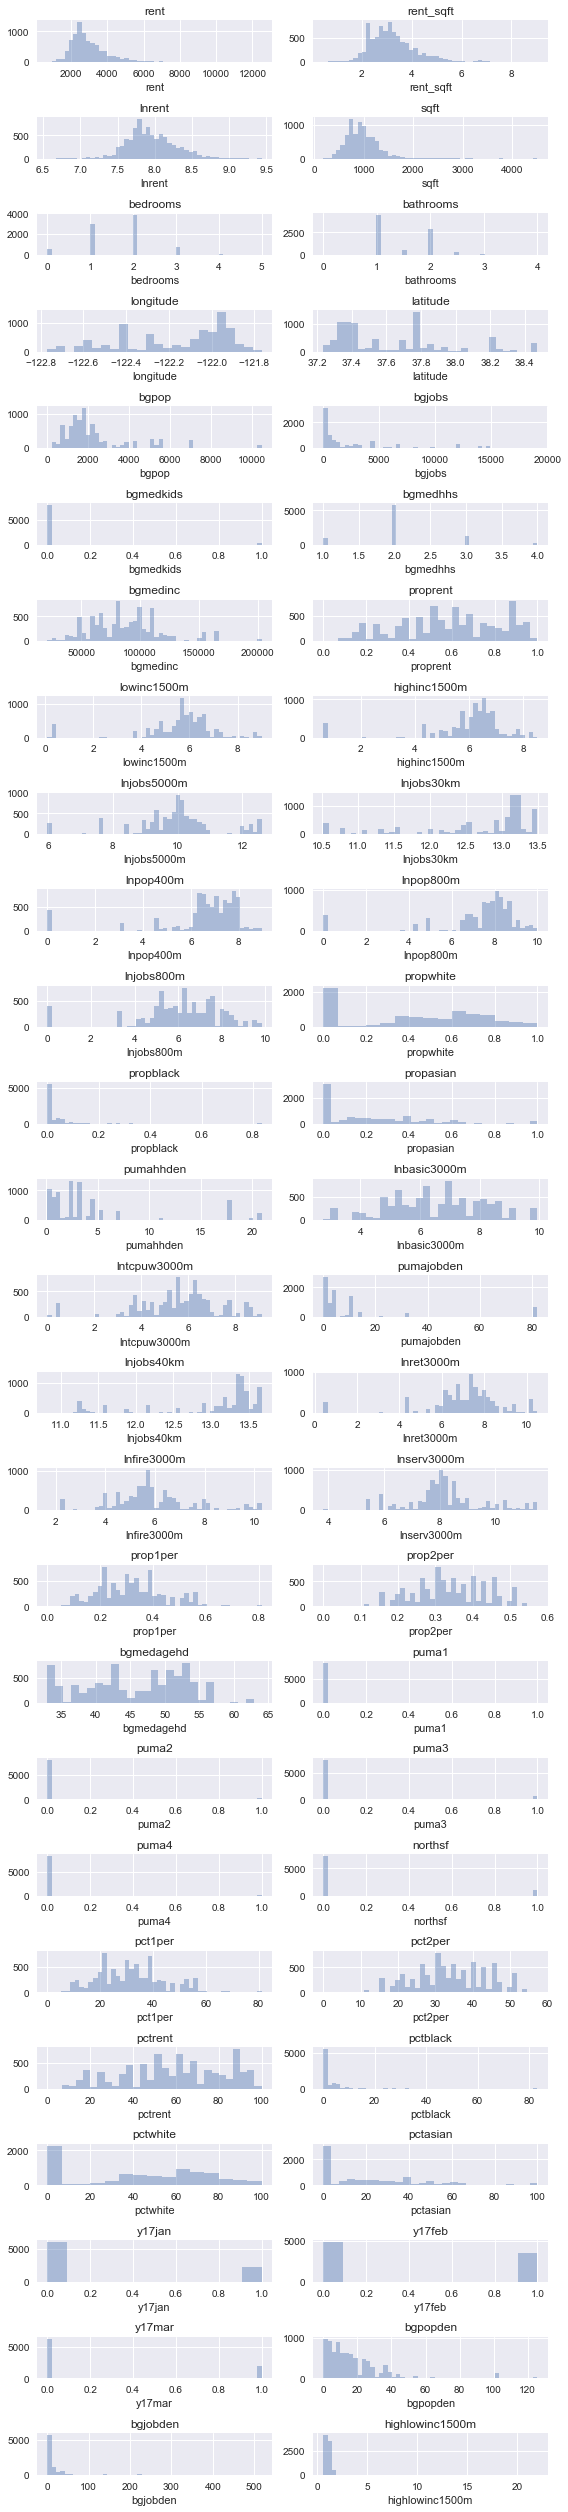

In [11]:
plot_rows = math.ceil(len(cols_to_use)/2)

f, axes = plt.subplots(plot_rows,2, figsize=(8,35))
sns.despine(left=True)

for i,col in enumerate(cols_to_use):
    row_position = math.floor(i/2)
    col_position = i%2
    sns.distplot(df_notnull[col], ax=axes[row_position, col_position],kde=False)
    axes[row_position, col_position].set_title('{}'.format(col)) 

plt.tight_layout()
plt.show()

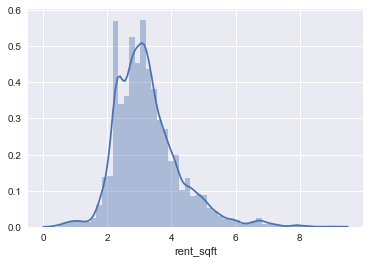

In [12]:
sns.distplot(df['rent_sqft'])

In [13]:
# $/sqft as a function of sqft 
#plt.scatter(df.sqft, df.rent_sqft)
#plt.ylabel('rent per sq ft')
#plt.xlabel('sqft')
#plt.show()

In [14]:
# Some useful summary stats
print('Mean rent: ${:.0f}'.format(df.rent.mean()),' | Median: ${:.0f}'.format(df.rent.median()))
print('Mean rent per square foot: ${:.2f}'.format(df.rent_sqft.mean()),' | Median: ${:.2f}'.format(df.rent_sqft.median()))
print('Mean sqft: {:.2f}'.format(df.sqft.mean()),' | Median: {:.2f}'.format(df.sqft.median()))

Mean rent: $2995  | Median: $2743
Mean rent per square foot: $3.24  | Median: $3.10
Mean sqft: 969.24  | Median: 925.00


### Create some additional features that might help

(Second iteration)

In the first iteration of models, there appeared to be an interaction effect with # bedrooms and # bathrooms; i.e., the number of bathrooms per bedroom seems to matter. E.g., a property with 4 bedrooms is probably not very desirable if it only has 1 bathroom, but might be much more desirable if it has 4 bedrooms and 3 bathrooms. So let's try adding a feature for bathrooms per bedroom.  (Turns out this improved the linear model but not GB.. as expected.)

In [15]:
def bath_var(row):
    """Make bathrooms/bedroom variable. """
    # Avoid 0 in demoninator. When bedrooms = 0, it's probably a studio. so for practical purposes, br=1
    if row['bedrooms']==0:
        br = 1
    else:
        br = row['bedrooms']
    return row['bathrooms']/br

# add a variable bath_bed (bathrooms per bedroom)
df['bath_bed'] = df.apply(bath_var, axis=1)
cols_to_use.append('bath_bed')
x_cols.append('bath_bed')

It also appears the relationship between rent and sqft is not linear. Let's add a sqft2 term

In [16]:
df['sqft2'] = df['sqft']**2
cols_to_use.append('sqft2')
x_cols.append('sqft2')

# Linear model

Try a linear model first, using rent/sqft as Y.
(I previously tried using lnrent as dependent variable, but rent/sqft results in a more accurate predictive model, and is more conceptual correct.)

In [17]:
from sklearn import linear_model, model_selection
from sklearn.metrics import r2_score

In [18]:
# define the data
df_y = df[y_col]
df_X = df[x_cols]
#sns.distplot(df['rent_sqft'])
#Downside of using $/sqft rather than lnrent is that the distribution is not as normally distributed. It's not that bad though.

In [19]:
# split into training and test sets
X_train, X_test, y_train, y_test = model_selection.train_test_split(df[x_cols],df[y_col], test_size = .3, random_state = 201)

# fit the model
regr = linear_model.LinearRegression()
regr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [20]:
# See mean square error, using test data
print("Mean squared error: {:.4f}".format(np.mean((regr.predict(X_test) - y_test) ** 2)))
print("RMSE: {:.4f}".format(np.sqrt(np.mean((regr.predict(X_test) - y_test) ** 2))))
# Explained variance score: 1 is perfect prediction. 
print('Variance score: {:.4f}'.format(regr.score(X_test, y_test)))
print('R2: {:.4f}'.format(r2_score(y_test, regr.predict(X_test))))  # ok, R2 is same as variance score

Mean squared error: 0.2770
RMSE: 0.5263
Variance score: 0.7326
R2: 0.7326


In [21]:
# Intercept
#print('Intercept:', regr.intercept_)

# The coefficients
#print('Coefficients:')
#pd.Series(regr.coef_, index=x_cols)

These coefficients aren't very useful without the standard errors. If I were interested in building a model for interpretation, I would use the statsmodels package, which has more functionality for statistical tests.

This variance (0.66) is a bit lower than the linear model using lnrent as Y (0.69), which is what we'd expect when we take the most important covariate and put it into the dependent variable. Still not a bad score here. Not great either, though. 

Added sqft as feature, with rent_sqft still as Y: 
- Mean squared error: 0.32
- RMSE: 0.56438373549
- Variance score: 0.69

Added bath/bedrooms feature

- Mean squared error: 0.31
- RMSE: 0.559876928818
- Variance score: 0.70

Added sqft^2 feature

- Mean squared error: 0.28
- RMSE: 0.526323190891
- Variance score: 0.73

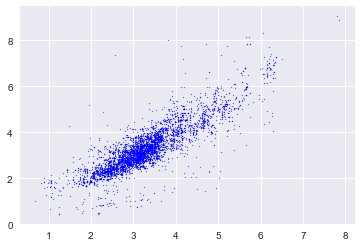

In [22]:
# It's always a good idea to plot the residuals to look for gross violations of linear regression.
# Plot predicted values vs. observed
plt.scatter(regr.predict(X_train),y_train, color='blue',s=1, alpha=.5)
plt.show()

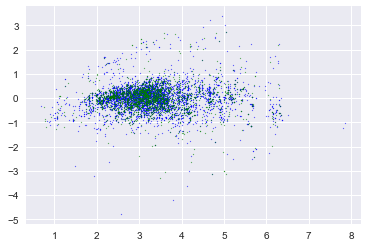

In [23]:
# plot residuals vs predicted values
plt.scatter(regr.predict(X_train), regr.predict(X_train)- y_train, color='blue',s=1, alpha=.5)
plt.scatter(regr.predict(X_test), regr.predict(X_test)- y_test, color='green',s=1, alpha=.5)
plt.show()

In [24]:
# Look for overfitting
print("Training set. Mean squared error: {:.5f}".format(np.mean((regr.predict(X_train) - y_train) ** 2)), '| Variance score: {:.5f}'.format(regr.score(X_train, y_train)))
print("Test set. Mean squared error: {:.5f}".format(np.mean((regr.predict(X_test) - y_test) ** 2)), '| Variance score: {:.5f}'.format(regr.score(X_test, y_test)))

Training set. Mean squared error: 0.24817 | Variance score: 0.74952
Test set. Mean squared error: 0.27702 | Variance score: 0.73259


Does not look like severe overfitting. (If there were, we'd probably have a much smaller error on training set and a larger error on test set.')
We do have a problem with colinearity and if we were using this model for interpretation we'd have to do better feature selection...

## Gradient boosting model


In [25]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble.partial_dependence import plot_partial_dependence
from sklearn.ensemble.partial_dependence import partial_dependence

In [26]:
def RMSE(y_actual, y_predicted):
    return np.sqrt(mean_squared_error(y_actual, y_predicted))

def cross_val_gb(X,y,cv_method='kfold',k=5, **params):
    """Estimate gradient boosting regressor using cross validation and return RMSE.
    
    Args: 
        X (DataFrame): features data
        y (Series): target data
        cv_method (str): how to split the data ('kfold' (default) or 'timeseries')
        k (int): number of folds (default=5)
        **params: keyword arguments for regressor
    Returns: 
        float: mean error (RMSE) across all training/test sets.
    """
    if cv_method == 'kfold':
        kf = KFold(n_splits=k, shuffle=True, random_state=2012016)  # use random seed for reproducibility. 
    
    E = np.ones(k)   # this array will hold the errors. 
    i=0
    for train, test in kf.split(X, y): 
        train_data_x = X.iloc[train]
        train_data_y = y.iloc[train]    
        test_data_x = X.iloc[test]
        test_data_y = y.iloc[test]

        # n_estimators is number of trees to build. 
        grad_boost = GradientBoostingRegressor(loss='ls',criterion='mse', **params)
        grad_boost.fit(train_data_x,train_data_y)
        predict_y=grad_boost.predict(test_data_x)
        E[i] = RMSE(test_data_y, predict_y)
        i+=1
    return np.mean(E)


In [27]:
# define the data
# because GB can model nonlinear relationships and interaction effects, we don't need sqft^2 or bed_bath as features. 
x_cols = ['sqft','bedrooms','bathrooms','longitude', 'latitude','bgpop','bgjobs', 'bgmedkids', 'bgmedhhs',
       'bgmedinc', 'proprent', 'lowinc1500m', 'highinc1500m', 'lnjobs5000m','lnjobs30km', 'lnpop400m', 'lnpop800m', 'lnjobs800m', 'propwhite',
       'propblack', 'propasian', 'pumahhden', 'lnbasic3000m', 'lntcpuw3000m','pumajobden', 'lnjobs40km', 'lnret3000m', 'lnfire3000m', 'lnserv3000m',
       'prop1per', 'prop2per', 'bgmedagehd', 'puma1', 'puma2', 'puma3','puma4', 'northsf', 'pct1per', 'pct2per', 'pctrent',
       'pctblack', 'pctwhite', 'pctasian', 'y17jan', 'y17feb', 'y17mar','bgpopden', 'bgjobden', 'highlowinc1500m']

df_X = df[x_cols]
y_col = 'rent_sqft'
df_y = df[y_col]
df_X.shape

(8253, 49)

In [28]:
# fit initial model (no paramter tuning)
params = {'n_estimators':100,
          'learning_rate':0.1,
          'max_depth':1,
          'min_samples_leaf':4
          }
grad_boost = GradientBoostingRegressor(loss='ls',criterion='mse', **params)
grad_boost.fit(df_X,df_y)
cross_val_gb(df_X,df_y, **params)

0.52580919721081787

Without parameter tuning, error is about the same as linear model. RMSE: 0.5258

**Tune the parameters**

In [29]:
# find the optimal parameters
param_grid = {'learning_rate':[.5 ,.1, .05],
              'max_depth':[2,4,6,12],
              'min_samples_leaf': [5,9,17],
              'max_features': [1, .3, .1]
              }

est= GradientBoostingRegressor(n_estimators = 500)
gs_cv = GridSearchCV(est,param_grid).fit(df_X,df_y)

In [30]:
# get optimal parameters
print(gs_cv.best_params_)
print(gs_cv.best_score_)

{'learning_rate': 0.1, 'max_depth': 2, 'max_features': 0.3, 'min_samples_leaf': 5}
0.649303767746


In [31]:
# fit the model with best parameters
params = {'n_estimators':500,
          'learning_rate':0.05,
          'max_depth':4,
          'min_samples_leaf':9,
          'max_features':.3
          }
grad_boost = GradientBoostingRegressor(loss='ls',criterion='mse', **params)
grad_boost.fit(df_X,df_y)
cross_val_gb(df_X,df_y, **params, k=3)

#RMSE: 0.37115

0.37294082132692341

In [32]:
# best parameters, using 1000 estimators
params = {'n_estimators':1000,
          'learning_rate':0.05,
          'max_depth':4,
          'min_samples_leaf':9,
          'max_features':.3
          }
grad_boost = GradientBoostingRegressor(loss='ls',criterion='mse', **params)
grad_boost.fit(df_X,df_y)
rmse_gb = cross_val_gb(df_X,df_y, **params, k=3)
print(rmse_gb)

0.361721542416


**without sqft as covariate**
- RMSE with 500 estimators: 0.4708
- RMSE with 1000 estimators: 0.4658
- linear model: 0.5965


**with sqft as covariate**
- RMSE with 500 estimators: 0.3712
- RMSE with 1000 estimators: 0.3620
- linear model: 0.5644


## Model evaluation and interpretation

In [33]:
# how "well" does the model do? 

print('Approx. percent error: {:.1f}%'.format(rmse_gb/df.rent_sqft.mean()*100))

print('Expected prediction error for the average housing unit: ${:.0f}'.format(rmse_gb*df.sqft.mean()))

Approx. percent error: 11.2%
Expected prediction error for the average housing unit: $351


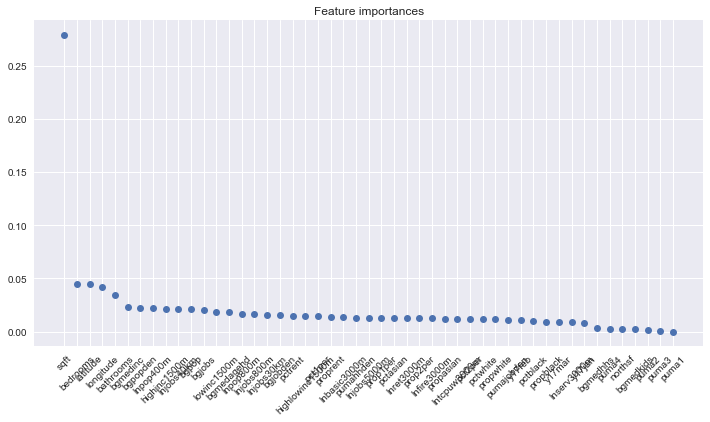

In [45]:
# plot the importances (Relative influence of each variable)
gb_o = pd.DataFrame({'features':x_cols,'importance':grad_boost.feature_importances_})
gb_o= gb_o.sort_values(by='importance',ascending=False)


plt.figure(1,figsize=(12, 6))
plt.xticks(range(len(gb_o)), gb_o.features,rotation=45)
plt.plot(range(len(gb_o)),gb_o.importance,"o")
plt.title('Feature importances')
plt.savefig(os.path.join(IMAGE_DIR, 'ft_importances.png'), dpi=150)
plt.show()

In [35]:
# choose features for partial dependent plots
#for i,col in enumerate(df_X.columns): 
#    print(i,col)

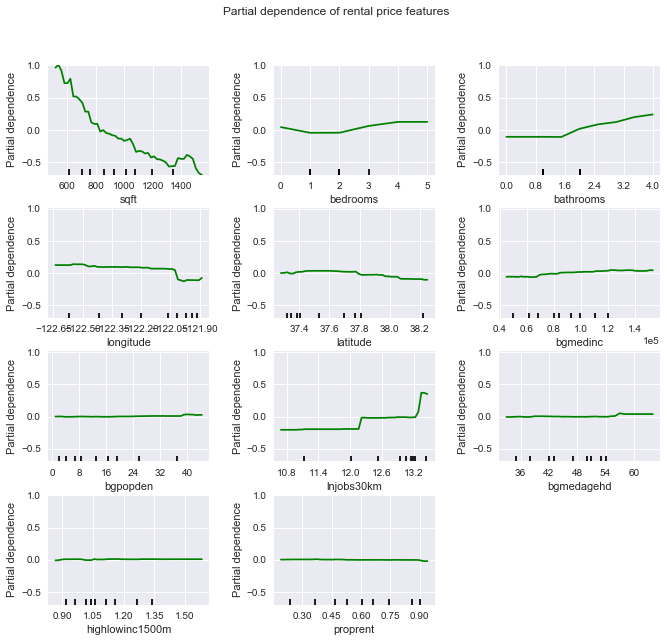

In [46]:
features = [0,1,2,3,4,9,46,14,31,48,10]
names = df_X.columns
fig, axs = plot_partial_dependence(grad_boost, df_X, features,feature_names=names, grid_resolution=50, figsize = (10,10))
fig.suptitle('Partial dependence of rental price features')
plt.subplots_adjust(top=0.9)  
plt.savefig(os.path.join(IMAGE_DIR, 'partial_depend.png'), dpi=150)
plt.show()

The partial dependence plots show how predicted values vary with the given covariate, "controlling for" the influence of other covariates ([Friedman, 2001](http://www.jstor.org/stable/pdf/2699986.pdf)). 

The first plot suggests a slightly nonlinear relationship between sqft and rent/sqft, which is what we predicted. The effect of additional floor area diminishes as the housing unit grows larger. There's an interesting bump around 1500sqft, which is hard to explain.

The lnjobs30km (log of number of jobs within 30km) also has some interesting non-linearities. There seem to be thresholds at which the concentration of jobs is high enough to have an effect.

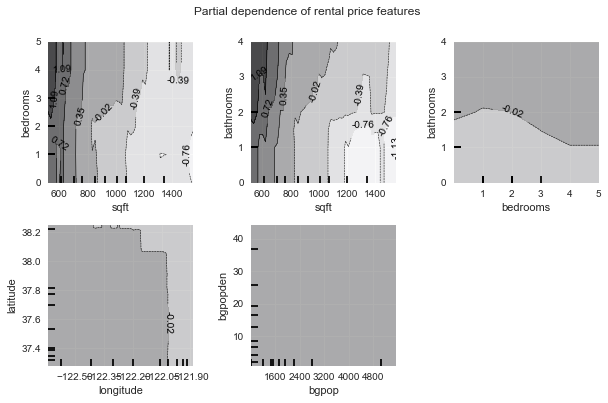

In [37]:
features = [(0,1),(0,2),(1,2),(3,4),(5,46)]
names = df_X.columns
fig, axs = plot_partial_dependence(grad_boost, df_X, features,feature_names=names, grid_resolution=50, figsize = (9,6))
fig.suptitle('Partial dependence of rental price features')
plt.subplots_adjust(top=0.9)  # tight_layout causes overlap with suptitle
plt.show()

These partial dependence contour plots show the interactions between covariates. We can see how this works in the third plot with bathrooms and bedrooms. For a house with 1 bedroom and 1 bathroom, adding an additional bathroom doesn't increase price that much. But a house with 3 bedrooms does get a price lift from having 2 bathrooms rather than 1. This all makes sense becuase you'd rarely need more bathrooms than bedrooms.

## Error analysis
- plot errors
- map errors by long/lat

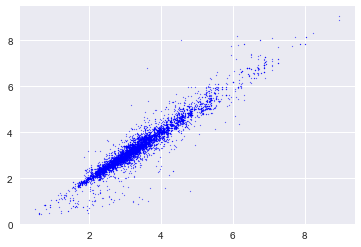

In [38]:
y_pred = grad_boost.predict(df_X)
# plot predicted vs. actual

plt.scatter(y_pred,df_y, color='blue',s=1, alpha=.5)
plt.show()

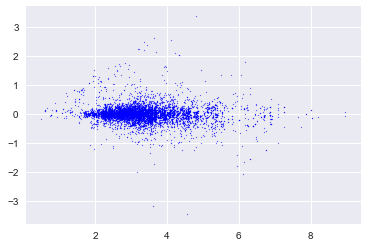

In [39]:
# plot errors vs. predicted
plt.scatter(y_pred, y_pred-df_y, color='blue',s=1,alpha=.5 )
plt.show()

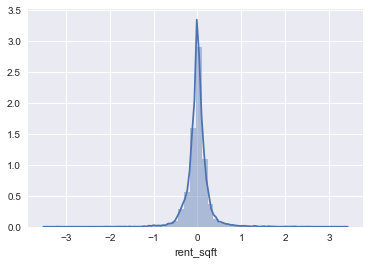

In [40]:
sns.distplot(y_pred-df_y)

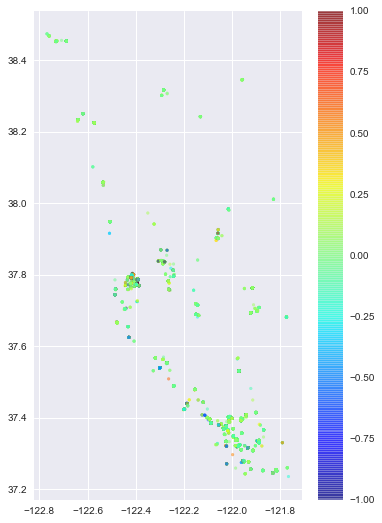

In [41]:
from matplotlib.colors import Normalize
# map the errors. 
x = df_X['longitude']
y = df_X['latitude']
z = y_pred-df_y

norm = Normalize(vmin=-1,vmax=1)  # zoom in on middle of error range

plt.figure(figsize=(6,9))
plt.scatter(x,y, c=z, cmap='jet',s=8,alpha=.5,edgecolors='face', norm=norm)
#plt.xlim(-122.6,-122)
#plt.ylim(37.6,38)
plt.colorbar()
plt.show()

# obs where abs(error)>0.8: 168


/Users/lisa/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:8: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  
/Users/lisa/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  if __name__ == '__main__':


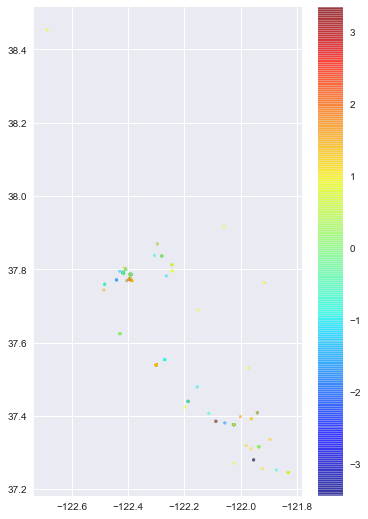

In [42]:
# it's hard to see a pattern in the above, but looks like errors are larger in the central city areas. 
# only show large errors, to make them more clear. 
# map the errors. 

err_cutoff = .8
print('# obs where abs(error)>{}:'.format(err_cutoff),len(z[abs(z)>err_cutoff]))
z_large_err = z[abs(z)>err_cutoff]
x_large_err = x.ix[z_large_err.index,]
y_large_err = y.ix[z_large_err.index,]


plt.figure(figsize=(6,9))
plt.scatter(x_large_err,y_large_err, c=z_large_err, cmap='jet',s=8,alpha=.5,edgecolors='face')

plt.colorbar()
plt.show()

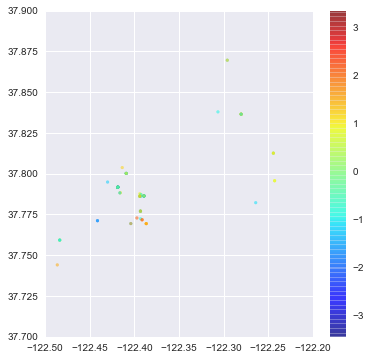

In [43]:
plt.figure(figsize=(6,6))
plt.scatter(x_large_err,y_large_err, c=z_large_err, cmap='jet',s=8,alpha=.5,edgecolors='face')
plt.xlim(-122.5,-122.2)
plt.ylim(37.7,37.9)
plt.colorbar()
plt.show()

I can't find a clear spatial pattern with the errors, which is good. It would still be a good idea to map these on a real map to see if there are spatial patterns the model hasn't accounted for even with the lat/long coordinates. 



# Ways to improve the model

- More considered feature selection. 
- Add features representing rental unit characteristics.
- Add dummies for administrative boundaries (cities, school districts). It's not clear this would improve the model much though, since we already have lat/long.
- Add features to represent crime and school quality
- Account for time series, as add more data. In short term, can add features for the day of week and day of month. (Does it matter when the listing was posted?)

# Results from previous iterations
### Linear model, using lnrent as Y

Scores for full dataset w/o bathrooms feature
- Mean squared error: 0.03
- RMSE: 0.186277629605
- Variance score: 0.68


Scores w/ bathrooms feature, dropping missing values - slightly better

- Mean squared error: 0.03
- RMSE: 0.181372180936
- Variance score: 0.69

Scores w/ bath_bed and sqft^2 features added

- Mean squared error: 0.03
- RMSE: 0.175778312162
- Variance score: 0.71

### Gradient boosting model with lnrent as Y

Best RMSE when using no bathrooms: 0.1308920

Best RMSE with bathrooms feature: 0.132212



I also tried a **random forest** model. The GB performs better. 